In [1]:
#importing all the required lib
import pandas as pd
import numpy as np 
import os
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import SpatialDropout1D, LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape,CuDNNLSTM
from keras.models import Sequential
from keras import Model,Input
from keras.layers.convolutional import Conv2D,Conv1D
import keras.backend as k
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import keras
from sklearn.utils import compute_class_weight
from keras.initializers import he_normal,glorot_normal
from keras.regularizers import l1,l2
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
from keras.callbacks import TensorBoard
from IPython.display import SVG, display
import pickle 
from keras.layers import LeakyReLU
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import pandas as pd
id = '1GpATd_pM4mcnWWIs28-s1lgqdAg2Wdv-'

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('preprocessed_data.csv')
df=pd.read_csv('preprocessed_data.csv')

id = '1pGd5tLwA30M7wkbJKdXHaae9tYVDICJ_'

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('glove_vectors')

import pickle
with open('glove_vectors', 'rb') as f:
    gmodel = pickle.load(f)
    glove_words =  (gmodel.keys())

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
data = pd.read_csv("/content/drive/My Drive/Assignments/preprocessed_data.csv")
data.shape

(109248, 9)

In [5]:
dbfile = open('/content/drive/My Drive/Assignments_DonorsChoose_2018/glove_vectors', 'rb')      
db = pickle.load(dbfile)

In [6]:
print(db["good"].shape)
print(db["good"][0:10])

(300,)
[-0.069254  0.37668  -0.16958  -0.27482   0.25667  -0.20293  -4.1122
  0.02595  -0.27085  -0.87003 ]


Each word is represented as a 300X1 dim vector and we printed the first 10values of a word "good"

In [7]:
data['remaining_input'] = data['teacher_number_of_previously_posted_projects']  +\
                                 data['price']

In [8]:
data.drop(["teacher_number_of_previously_posted_projects","price"],axis = 1 ,inplace = True)

In [9]:
data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'project_is_approved', 'clean_categories', 'clean_subcategories',
       'essay', 'remaining_input'],
      dtype='object')

In [10]:
y=data["project_is_approved"]
data.drop("project_is_approved",axis = 1,inplace=True)
print(f"Target:{y.shape}\n Input {data.shape}")

Target:(109248,)
 Input (109248, 7)


Now let's investigate each features 

# Splitting our data into train and test

In [11]:
# Split Train, CV and Test data (64, 16, 20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, stratify=y,random_state=5)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train,random_state=5)

print('Train Data', X_train.shape, y_train.shape)
print('Cross-Validation Data', X_cv.shape, y_cv.shape)
print('Test Data', X_test.shape, y_test.shape)

Train Data (69918, 7) (69918,)
Cross-Validation Data (17480, 7) (17480,)
Test Data (21850, 7) (21850,)


In [12]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_cv = to_categorical(y_cv)
y_test = to_categorical(y_test)

Now let's prepare our features for embedding

## School-State

In [13]:
from sklearn.preprocessing import LabelEncoder
class LabelEncoderExt(object):
      def __init__(self):
         self.label_encoder = LabelEncoder()
      # self.classes_ = self.label_encoder.classes_
      def fit(self, data_list):
     
          self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
          self.classes_ = self.label_encoder.classes_
          return self
      def transform(self, data_list):
      
          new_data_list = list(data_list)
          for unique_item in np.unique(data_list):
              if unique_item not in self.label_encoder.classes_:
                      new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]
          return self.label_encoder.transform(new_data_list)


     




In [14]:
from keras.preprocessing import sequence
train_sch_state = X_train.school_state.values
test_sch_state = X_test.school_state.values
cv_sch_state = X_cv.school_state.values
# tokenizer = Tokenizer() #using the TOkenizer function creating an object tokenizer
# tokenizer.fit_on_texts(train_sch_state)#training on train data
# train_sch_state = tokenizer.texts_to_sequences(train_sch_state)#converting text to squences 
# test_sch_state = tokenizer.texts_to_sequences(test_sch_state)
# cv_sch_state = tokenizer.texts_to_sequences(cv_sch_state)
# x_train_sch_state = sequence.pad_sequences(train_sch_state, maxlen = max_length, padding='post')
# x_test_sch_state = sequence.pad_sequences(test_sch_state, maxlen = max_length, padding='post')
# x_cv_sch_state = sequence.pad_sequences(cv_sch_state, maxlen = max_length, padding='post')

In [15]:
le1=LabelEncoderExt()
le1.fit(train_sch_state)
x_train_sch_state=le1.transform(train_sch_state)
x_cv_sch_state=le1.transform(cv_sch_state)
x_test_sch_state=le1.transform(test_sch_state)




In [16]:
train_proj_grade = X_train.project_grade_category.values
test_proj_grade = X_test.project_grade_category.values
cv_proj_grade = X_cv.project_grade_category.values
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(train_proj_grade)
# train_proj_grade = tokenizer.texts_to_sequences(train_proj_grade)
# test_proj_grade = tokenizer.texts_to_sequences(test_proj_grade)
# cv_proj_grade = tokenizer.texts_to_sequences(cv_proj_grade)
# x_train_proj_grade = sequence.pad_sequences(train_proj_grade, maxlen = max_length, padding='post')
# x_test_proj_grade = sequence.pad_sequences(test_proj_grade, maxlen = max_length, padding='post')
# x_cv_proj_grade = sequence.pad_sequences(cv_proj_grade, maxlen = max_length, padding='post')
le1=LabelEncoderExt()
le1.fit(train_proj_grade)
x_train_proj_grade=le1.transform(train_proj_grade)
x_cv_proj_grade=le1.transform(cv_proj_grade)
x_test_proj_grade=le1.transform(test_proj_grade)

#Clean Categories

In [17]:
train_clean_cat = X_train.clean_categories.values
test_clean_cat = X_test.clean_categories.values
cv_clean_cat = X_cv.clean_categories.values
le1=LabelEncoderExt()
le1.fit(train_clean_cat)
x_train_clean_cat=le1.transform(train_clean_cat)
x_cv_clean_cat=le1.transform(cv_clean_cat)
x_test_clean_cat=le1.transform(test_clean_cat)

In [18]:
train_clean_sub_cat = X_train.clean_subcategories.values
test_clean_sub_cat = X_test.clean_subcategories.values
cv_clean_sub_cat = X_cv.clean_subcategories.values
le1=LabelEncoderExt()
le1.fit(train_clean_sub_cat)
x_train_clean_sub_cat=le1.transform(train_clean_sub_cat)
x_cv_clean_sub_cat=le1.transform(cv_clean_sub_cat)
x_test_clean_sub_cat=le1.transform(test_clean_sub_cat)


In [20]:
train_teacher_prefix = X_train.teacher_prefix.values
test_teacher_prefix = X_test.teacher_prefix.values
cv_teacher_prefix = X_cv.teacher_prefix.values
le1=LabelEncoderExt()
le1.fit(train_teacher_prefix)
x_train_teacher_prefix=le1.transform(train_teacher_prefix)
x_cv_teacher_prefix=le1.transform(cv_teacher_prefix)
x_test_teacher_prefix=le1.transform(test_teacher_prefix)

#Teacher-Prefix

In [ ]:
# train_teacher_prefix = X_train.teacher_prefix.values
# test_teacher_prefix = X_test.teacher_prefix.values
# cv_teacher_prefix = X_cv.teacher_prefix.values
# max_length = 1
# # tokenizer = Tokenizer()
# tokenizer.fit_on_texts(train_teacher_prefix)
# train_teacher_prefix = tokenizer.texts_to_sequences(train_teacher_prefix)
# test_teacher_prefix = tokenizer.texts_to_sequences(test_teacher_prefix)
# cv_teacher_prefix = tokenizer.texts_to_sequences(cv_teacher_prefix)
# x_train_teacher_prefix = sequence.pad_sequences(train_teacher_prefix, maxlen = max_length, padding='post')
# x_test_teacher_prefix = sequence.pad_sequences(test_teacher_prefix, maxlen = max_length, padding='post')
# x_cv_teacher_prefix = sequence.pad_sequences(cv_teacher_prefix, maxlen = max_length, padding='post')

#Numerical Featurization

In [21]:
X_train["remaining_input"] = X_train["remaining_input"].values.reshape(-1,1)
X_train["remaining_input"].shape
from sklearn.preprocessing import MinMaxScaler , StandardScaler

scalar = StandardScaler()
scalar.fit(X_train["remaining_input"].values.reshape(-1,1))
x_train_num = scalar.transform(X_train["remaining_input"].values.reshape(-1,1))
x_test_num = scalar.transform(X_test["remaining_input"].values.reshape(-1,1))
x_cv_num = scalar.transform(X_cv["remaining_input"].values.reshape(-1,1))
print(x_train_num.shape)
print(x_train_num)


(69918, 1)
[[-0.33347414]
 [-0.56713156]
 [ 3.04850062]
 ...
 [ 0.18106669]
 [-0.43048112]
 [-0.43015144]]


# Text Data Vectorization

#Assignment-2

In [22]:
vectorizer = TfidfVectorizer() #Defining TFIDF with min_df=10
imp_tf = vectorizer.fit(X_train.essay)

In [23]:
idf_values = vectorizer.idf_
print(idf_values.shape)

(47206,)


In [24]:
tfidf_df= pd.DataFrame(idf_values, columns= ["idf"])
tfidf_df.head()

,idf
0,7.206333
1,5.910926
2,11.461946
3,11.461946
4,11.461946


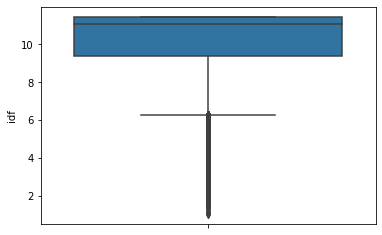

In [25]:
import seaborn as sns
sns.boxplot(y = "idf", data = tfidf_df )

In [26]:
all_words_dict = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
chosen_words_dict = {}
for k,v in all_words_dict.items():
 if v > 4 and v < 11:
    chosen_words_dict[k] = v

In [27]:
from tqdm import tqdm
def remove_words_with_idfValue(sentences):
  processed=[]
  for sent in tqdm(sentences):
    sent_lis = sent.split()
    new_sent = []
    for word in sent_lis:
      if chosen_words_dict.get(word):
        new_sent.append(word)
    processed.append(' '.join(new_sent))
  return processed

In [28]:
x_train_imp = remove_words_with_idfValue(X_train.essay)
x_cross_imp = remove_words_with_idfValue(X_cv.essay)
x_test_imp = remove_words_with_idfValue(X_test.essay)

100%|██████████| 21850/21850 [00:01<00:00, 21533.46it/s]


In [29]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
def padded(encoded_docs):  
  max_length = 400
  padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
  return padded_docs

In [30]:
#https://stackoverflow.com/posts/51956230/revisions
t = Tokenizer()
t.fit_on_texts(x_train_imp)
vocab_size = len(t.word_index) + 1
print(vocab_size)
# integer encode the documents
encoded_docs = t.texts_to_sequences(x_train_imp)
essay_padded_train = padded(encoded_docs)

23093


In [32]:
#t = Tokenizer()
#t.fit_on_texts(x_cross_imp)
#vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(x_cross_imp)
essay_padded_cv = padded(encoded_docs)

In [33]:
#t = Tokenizer()
#t.fit_on_texts(x_test_imp)
# vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(x_test_imp)
essay_padded_test = padded(encoded_docs)

In [35]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = db.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(23093, 300)


In [36]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
min_max = StandardScaler()
min_max.fit(X_train["remaining_input"].values.reshape(-1,1))
x_train_num = min_max.transform(X_train["remaining_input"].values.reshape(-1,1))
x_test_num = min_max.transform(X_test["remaining_input"].values.reshape(-1,1))
x_cv_num = min_max.transform(X_cv["remaining_input"].values.reshape(-1,1))
print(x_train_num.shape)
print(x_train_num)

(69918, 1)
[[-0.33347414]
 [-0.56713156]
 [ 3.04850062]
 ...
 [ 0.18106669]
 [-0.43048112]
 [-0.43015144]]


In [60]:
from keras.optimizers import Adam
#input 1
input_1 = Input(shape=(400,))
x1 =Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=400, trainable=False)(input_1)
#what are spartial dropouts - https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/
#https://stackoverflow.com/questions/50393666/how-to-understand-spatialdropout1d-and-when-to-use-it
x1 = LSTM(128,activation='relu',return_sequences=True, recurrent_dropout=0.5)(x1)
x1 = Flatten()(x1)

#input 2
input_2 = Input(shape=(1,))#school_state
x2 = Embedding(input_dim= 52, output_dim= min(52//2,50))(input_2)
x2 = Flatten()(x2)

#input 3
input_3 = Input(shape=(1,)) #project_grade
x3 = Embedding(input_dim = 52, output_dim= min(52//2,50))(input_3)
x3 = Flatten()(x3)

#input 4
input_4 = Input(shape=(1,)) #clean_categories
x4 = Embedding(input_dim=52,output_dim= min(52//2,50))(input_4)
x4 = Flatten()(x4)

#input 5
input_5 = Input(shape=(1,)) #clean_subcategories
x5 = Embedding(input_dim= 390, output_dim= min(390//2,50))(input_5)
x5 = Flatten()(x5)

#input 6
input_6 = Input(shape=(1,))#teacher_prefix
x6 = Embedding(input_dim= 6,output_dim= min(3,50))(input_6)
x6 = Flatten()(x6)

#input 7
input_7 = Input(shape=(1,)) #numerical
x7 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input_7)

#merging all the inputs 
x = concatenate([x1,x2,x3,x4,x5,x6,x7])

x=BatchNormalization()(x)
#x= Dense(1024, activation='relu')(x)
#x= LeakyReLU(alpha = 0.3)(x)
#x= Dropout(0.8)(x)
#x= Dense(512, activation='relu')(x)
#x= LeakyReLU(alpha = 0.3)(x)
#x= Dropout(0.7)(x)
x= Dense(256,kernel_initializer=he_normal(),activation='relu',kernel_regularizer=l2(0.001))(x)
#x= LeakyReLU(alpha = 0.3)(x)
x= Dropout(0.6)(x)
x=BatchNormalization()(x)
x= Dense(128,kernel_initializer=he_normal(),activation='relu',kernel_regularizer=l2(0.001))(x)
#x= LeakyReLU(alpha = 0.3)(x)
x= Dropout(0.5)(x)
x= Dense(64,kernel_initializer=he_normal(),activation='relu',kernel_regularizer=l2(0.001))(x)
#x= LeakyReLU(alpha = 0.3)(x)
x= Dropout(0.4)(x)
#x= Dense(1024)(x)
#x= LeakyReLU(alpha = 0.3)(x)
#x= Dropout(0.5)(x)
#x=BatchNormalization()(x)
x= Dense(32,kernel_initializer=he_normal(),activation='relu',kernel_regularizer=l2(0.001))(x)
#x= LeakyReLU(alpha = 0.3)(x)
x= Dropout(0.5)(x)
#x=BatchNormalization()(x)
x= Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.002))(x)
#x= LeakyReLU(alpha = 0.3)(x)
#x= Dropout(0.25)(x)
output=Dense(2, activation='softmax')(x)
model2 = Model([input_1, input_2, input_3, input_4, input_5, input_6, input_7], output)

In [61]:
model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_31 (Embedding)        (None, 400, 300)     6927900     input_36[0][0]                   
__________________________________________________________________________________________________
input_37 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           (None, 1)            0                                            
____________________________________________________________________________________________

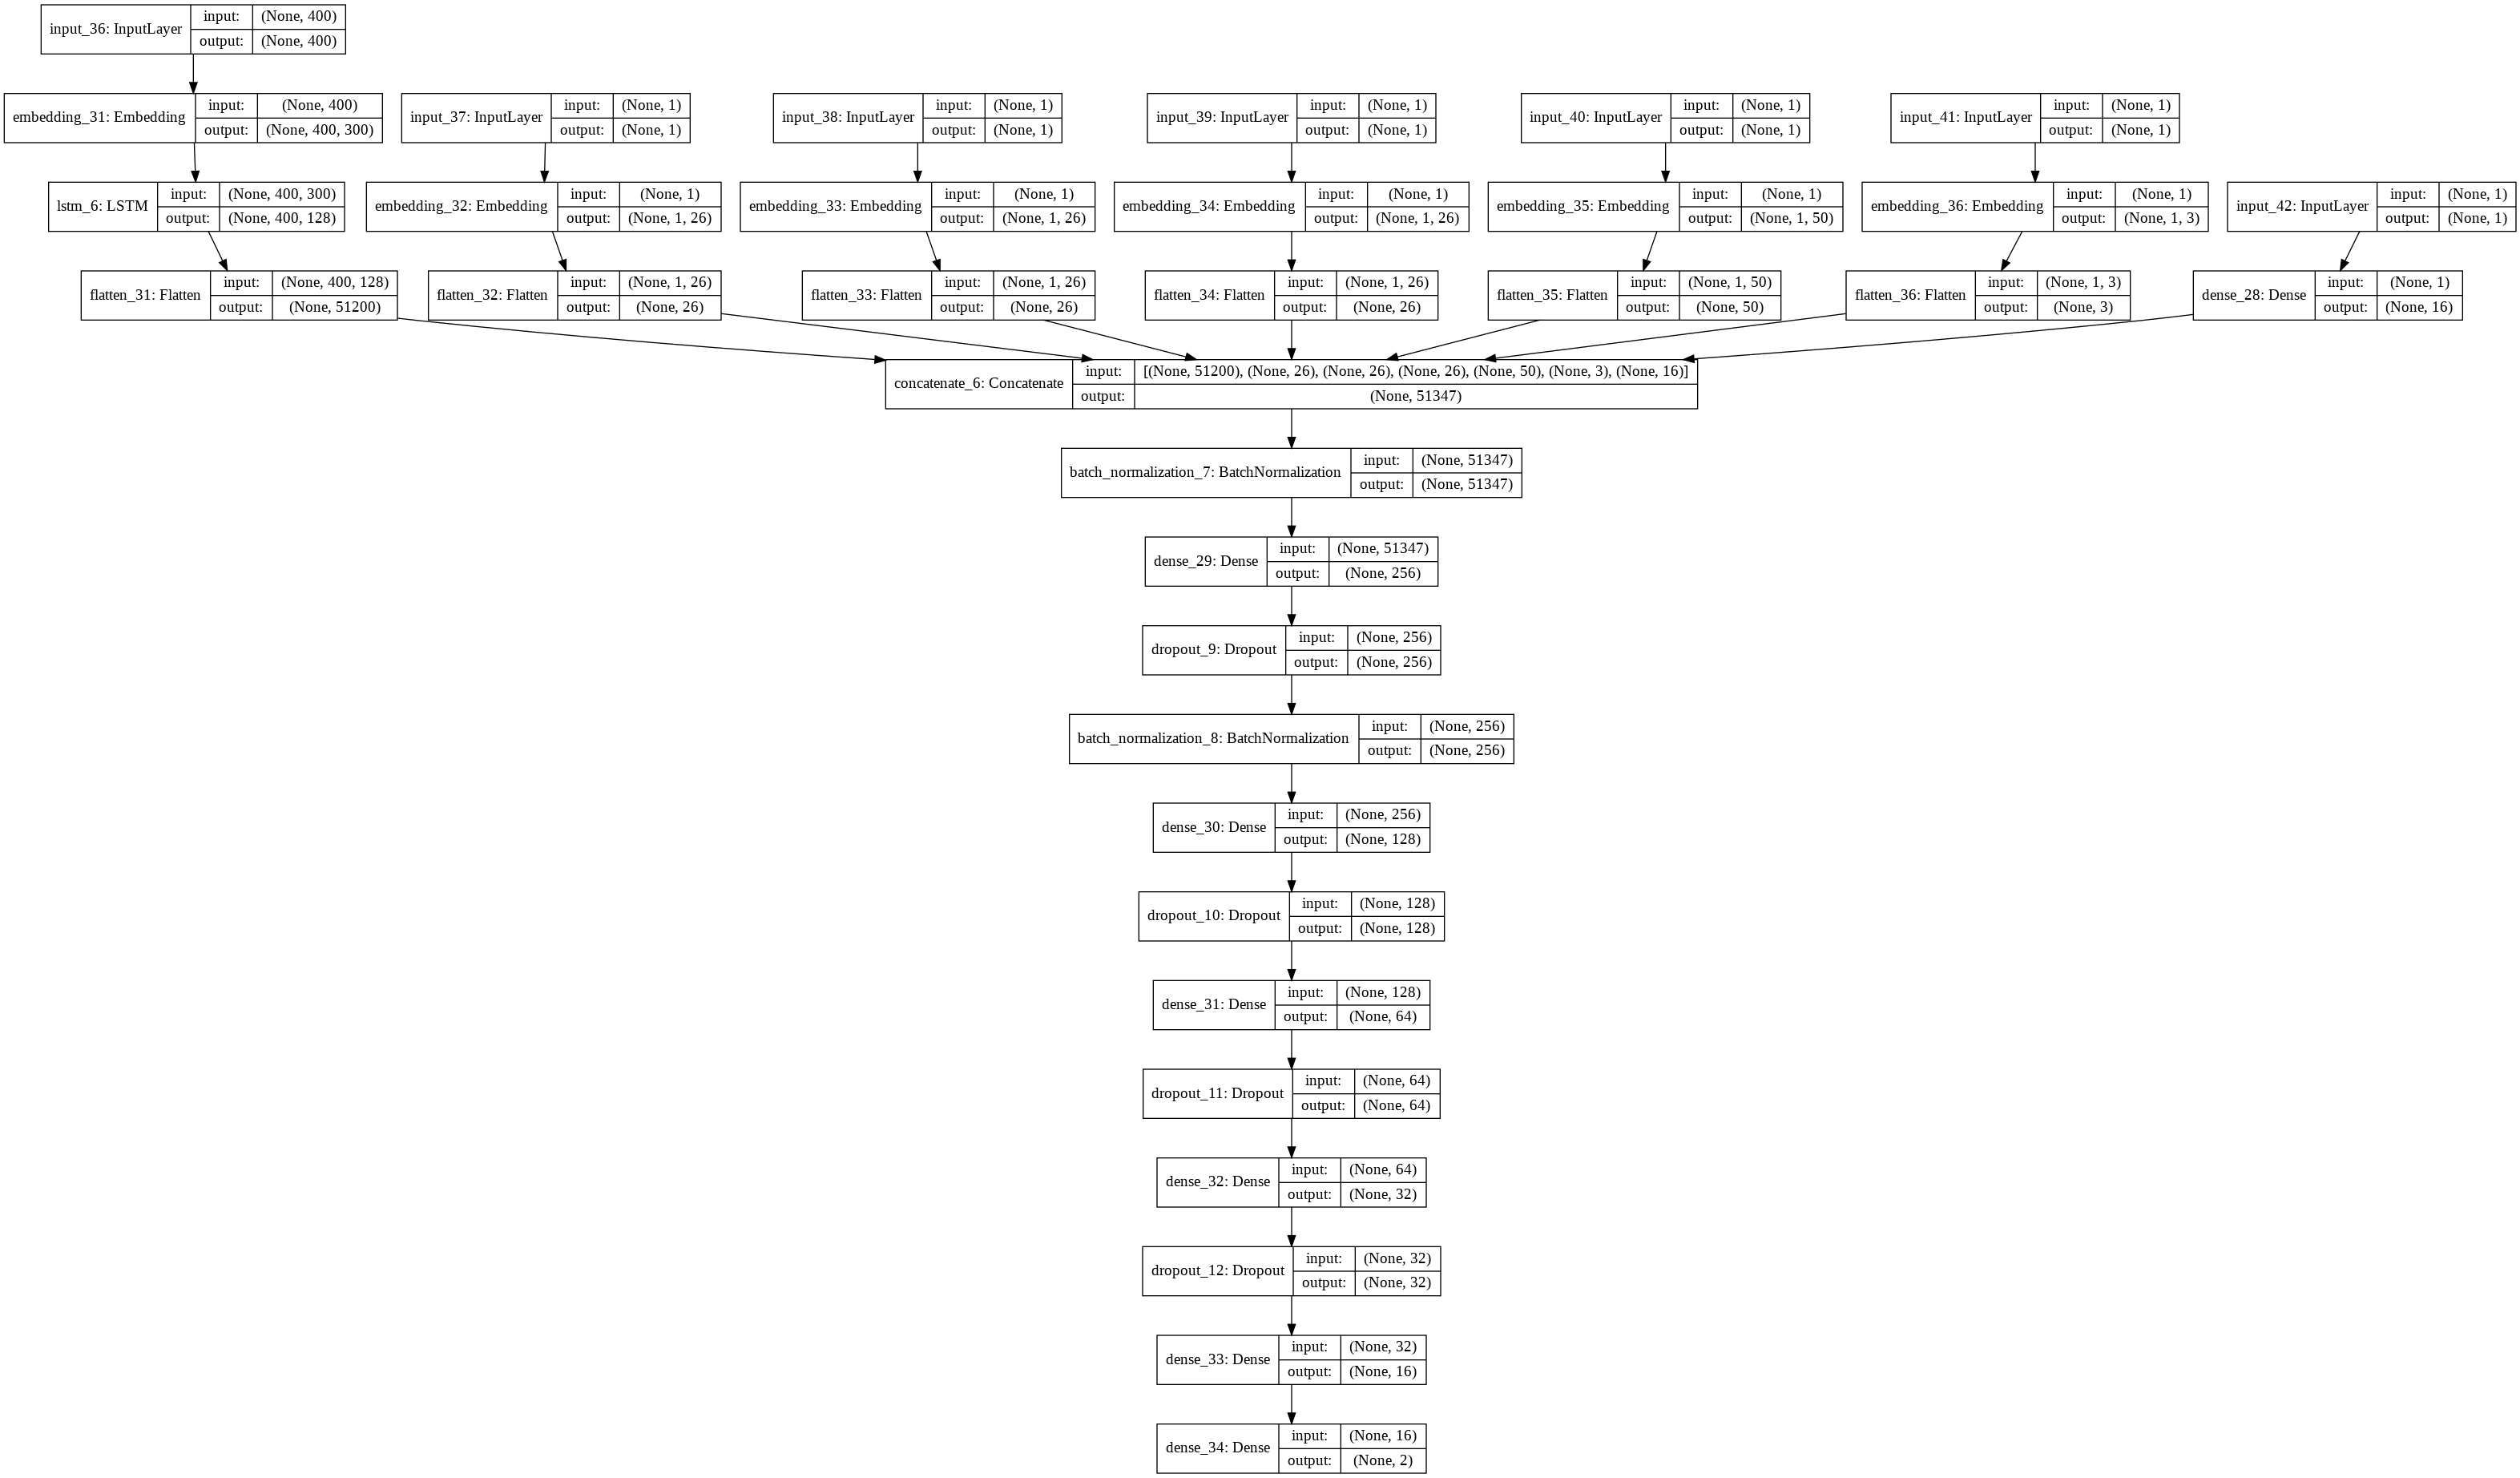

In [62]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model2, to_file='/content/drive/My Drive/LSTM_Output/model_2.png', show_shapes=True, show_layer_names=True)

In [38]:
x_train = [essay_padded_train ,x_train_sch_state,x_train_proj_grade,x_train_clean_cat,x_train_clean_sub_cat,x_train_teacher_prefix,x_train_num]
x_test = [essay_padded_test,x_test_sch_state,x_test_proj_grade,x_test_clean_cat,x_test_clean_sub_cat,x_test_teacher_prefix,x_test_num]
x_cv = [essay_padded_cv ,x_cv_sch_state,x_cv_proj_grade,x_cv_clean_cat,x_cv_clean_sub_cat,x_cv_teacher_prefix,x_cv_num]

In [39]:
#https://stackoverflow.com/posts/51734992/revisions
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [63]:
adam = keras.optimizers.Adam(lr=0.0001)
model2.compile(optimizer=adam, loss='categorical_crossentropy',metrics=[auroc])

In [64]:
from keras.callbacks import *
filepath="/content/drive/My Drive/LSTM_Output/epochs:{epoch:03d}-val_acc:{val_auroc:.3f}.hdf5"
checkpoint_2 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, mode='max')

In [41]:
y_train.shape

(69918, 2)

In [65]:
filepath = "/content/drive/My Drive/weights_2.best.hdf5"
earlystopping2 = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

#checkpoint2 = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
tensorboard = TensorBoard(log_dir="/content/drive/My Drive/LSTM_Output/logs/{}".format(time()))
callbacks_list = [checkpoint_2,tensorboard, earlystopping2]#, reduce_lr2]

history2= model2.fit(x_train, y_train, epochs=20, verbose=1, batch_size=512, validation_data=(x_cv  , y_cv),callbacks=callbacks_list)
#model2.save('/content/drive/My Drive/weights_2.best.hdf5')

Train on 69918 samples, validate on 17480 samples
Epoch 1/20
69918/69918 [==============================] - 219s 3ms/step - loss: 1.6118 - auroc: 0.5069 - val_loss: 1.2884 - val_auroc: 0.5343

Epoch 00001: saving model to /content/drive/My Drive/LSTM_Output/epochs:001-val_acc:0.534.hdf5
Epoch 2/20
69918/69918 [==============================] - 213s 3ms/step - loss: 1.2814 - auroc: 0.5174 - val_loss: 1.2380 - val_auroc: 0.5741

Epoch 00002: saving model to /content/drive/My Drive/LSTM_Output/epochs:002-val_acc:0.574.hdf5
Epoch 3/20
69918/69918 [==============================] - 214s 3ms/step - loss: 1.2054 - auroc: 0.5347 - val_loss: 1.2141 - val_auroc: 0.5765

Epoch 00003: saving model to /content/drive/My Drive/LSTM_Output/epochs:003-val_acc:0.577.hdf5
Epoch 4/20
69918/69918 [==============================] - 214s 3ms/step - loss: 1.1531 - auroc: 0.5565 - val_loss: 1.1867 - val_auroc: 0.6101

Epoch 00004: saving model to /content/drive/My Drive/LSTM_Output/epochs:004-val_acc:0.610.hdf

In [67]:
model2.save('/content/drive/My Drive/weights_2.best.hdf5')

In [70]:
from keras.optimizers import Adam
#input 1
input_1 = Input(shape=(400,))
x1 =Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=400, trainable=False)(input_1)
#what are spartial dropouts - https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/
#https://stackoverflow.com/questions/50393666/how-to-understand-spatialdropout1d-and-when-to-use-it
x1 = LSTM(128,activation='relu',return_sequences=True, recurrent_dropout=0.5)(x1)
x1 = Flatten()(x1)

#input 2
input_2 = Input(shape=(1,))#school_state
x2 = Embedding(input_dim= 52, output_dim= min(52//2,50))(input_2)
x2 = Flatten()(x2)

#input 3
input_3 = Input(shape=(1,)) #project_grade
x3 = Embedding(input_dim = 52, output_dim= min(52//2,50))(input_3)
x3 = Flatten()(x3)

#input 4
input_4 = Input(shape=(1,)) #clean_categories
x4 = Embedding(input_dim=52,output_dim= min(52//2,50))(input_4)
x4 = Flatten()(x4)

#input 5
input_5 = Input(shape=(1,)) #clean_subcategories
x5 = Embedding(input_dim= 390, output_dim= min(390//2,50))(input_5)
x5 = Flatten()(x5)

#input 6
input_6 = Input(shape=(1,))#teacher_prefix
x6 = Embedding(input_dim= 6,output_dim= min(3,50))(input_6)
x6 = Flatten()(x6)

#input 7
input_7 = Input(shape=(1,)) #numerical
x7 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input_7)

#merging all the inputs 
x = concatenate([x1,x2,x3,x4,x5,x6,x7])

x=BatchNormalization()(x)
#x= Dense(1024, activation='relu')(x)
#x= LeakyReLU(alpha = 0.3)(x)
#x= Dropout(0.8)(x)
#x= Dense(512, activation='relu')(x)
#x= LeakyReLU(alpha = 0.3)(x)
#x= Dropout(0.7)(x)
x= Dense(256,kernel_initializer=he_normal(),activation='relu',kernel_regularizer=l2(0.001))(x)
#x= LeakyReLU(alpha = 0.3)(x)
x= Dropout(0.6)(x)
x=BatchNormalization()(x)
x= Dense(128,kernel_initializer=he_normal(),activation='relu',kernel_regularizer=l2(0.001))(x)
#x= LeakyReLU(alpha = 0.3)(x)
x= Dropout(0.5)(x)
x= Dense(64,kernel_initializer=he_normal(),activation='relu',kernel_regularizer=l2(0.001))(x)
#x= LeakyReLU(alpha = 0.3)(x)
x= Dropout(0.4)(x)
#x= Dense(1024)(x)
#x= LeakyReLU(alpha = 0.3)(x)
#x= Dropout(0.5)(x)
#x=BatchNormalization()(x)
x= Dense(32,kernel_initializer=he_normal(),activation='relu',kernel_regularizer=l2(0.001))(x)
#x= LeakyReLU(alpha = 0.3)(x)
x= Dropout(0.5)(x)
#x=BatchNormalization()(x)
x= Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.002))(x)
#x= LeakyReLU(alpha = 0.3)(x)
#x= Dropout(0.25)(x)
output=Dense(2, activation='softmax')(x)
model2 = Model([input_1, input_2, input_3, input_4, input_5, input_6, input_7], output)

#tensorboard = TensorBoard(log_dir="logs".format(time()))
#tensorboard = TensorBoard(log_dir="/content/drive/My Drive/LSTM_Output/logs/{}".format(time()))
#model2.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0006,decay = 1e-4), metrics=[auroc])
model2.load_weights("/content/drive/My Drive/LSTM_Output/epochs:018-val_acc:0.685.hdf5")

In [71]:
print("Auc for test data: %0.3f"%roc_auc_score(y_test,model2.predict(x_test)))
print("Auc for CV data: %0.3f"%roc_auc_score(y_cv,model2.predict(x_cv)))
print("Auc for train data: %0.3f"%roc_auc_score(y_train,model2.predict(x_train)))

Auc for test data: 0.699
Auc for CV data: 0.684
Auc for train data: 0.771


In [72]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

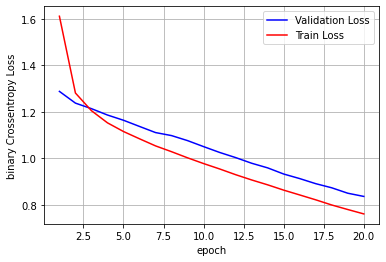

In [73]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,20+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history2.history['val_loss']
ty = history2.history['loss']
plt_dynamic(x, vy, ty, ax)

In [74]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation auroc")
    ax.plot(x, ty, 'r', label="Train auroc")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

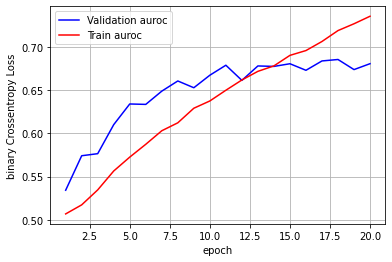

In [75]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary Crossentropy Loss')

vy = history2.history['val_auroc']
ty = history2.history['auroc']
plt_dynamic(x, vy, ty, ax)

#Assignment- 3

#One-Hot Encoding Categoical Values

In [ ]:
X_train.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'clean_categories', 'clean_subcategories', 'essay', 'remaining_input'],
      dtype='object')

In [ ]:
# Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors
# Neumerical values

# One hot encoding of Categorical Feature
# - school_state : categorical data
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values)# Training

X_train_school_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_school_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_school_state_ohe = vectorizer.transform(X_test['school_state'].values)

school_state_features = vectorizer.get_feature_names()

print(X_train_school_state_ohe.shape, y_train.shape)
print(X_cv_school_state_ohe.shape, y_cv.shape)
print(X_test_school_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print('*'*100)



(69918, 51) (69918, 2)
(17480, 51) (17480, 2)
(21850, 51) (21850, 2)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
****************************************************************************************************


In [ ]:
# Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors
# Neumerical values

# One hot encoding of Categorical Feature
# - teacher_prefix : categorical data
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values)# Training

X_train_teacher_prefix_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_prefix_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_prefix_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

teacher_prefix_features = vectorizer.get_feature_names()

print(X_train_teacher_prefix_ohe.shape, y_train.shape)
print(X_cv_teacher_prefix_ohe.shape, y_cv.shape)
print(X_test_teacher_prefix_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print('*'*100)



(69918, 5) (69918, 2)
(17480, 5) (17480, 2)
(21850, 5) (21850, 2)
['dr', 'mr', 'mrs', 'ms', 'teacher']
****************************************************************************************************


In [ ]:
# Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors
# Neumerical values

# One hot encoding of Categorical Feature
# - project_grade_category : categorical data
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values)# Training

X_train_project_grade_category_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_project_grade_category_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_project_grade_category_ohe = vectorizer.transform(X_test['project_grade_category'].values)

project_grade_category_features = vectorizer.get_feature_names()

print(X_train_project_grade_category_ohe.shape, y_train.shape)
print(X_cv_project_grade_category_ohe.shape, y_cv.shape)
print(X_test_project_grade_category_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print('*'*100)



(69918, 4) (69918, 2)
(17480, 4) (17480, 2)
(21850, 4) (21850, 2)
['grades35', 'grades68', 'grades912', 'gradesprek2']
****************************************************************************************************


In [ ]:
# Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors
# Neumerical values

# One hot encoding of Categorical Feature
# - clean_categories : categorical data
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values)# Training

X_train_clean_categories_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_clean_categories_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_clean_categories_ohe = vectorizer.transform(X_test['clean_categories'].values)

project_grade_category_features = vectorizer.get_feature_names()

print(X_train_clean_categories_ohe.shape, y_train.shape)
print(X_cv_clean_categories_ohe.shape, y_cv.shape)
print(X_test_clean_categories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print('*'*100)



(69918, 9) (69918, 2)
(17480, 9) (17480, 2)
(21850, 9) (21850, 2)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
****************************************************************************************************


In [ ]:
# Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors
# Neumerical values

# One hot encoding of Categorical Feature
# - clean_subcategories : categorical data
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values)# Training

X_train_clean_subcategories_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_clean_subcategories_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_clean_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

project_grade_subcategory_features = vectorizer.get_feature_names()

print(X_train_clean_subcategories_ohe.shape, y_train.shape)
print(X_cv_clean_subcategories_ohe.shape, y_cv.shape)
print(X_test_clean_subcategories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print('*'*100)



(69918, 30) (69918, 2)
(17480, 30) (17480, 2)
(21850, 30) (21850, 2)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']
****************************************************************************************************


In [ ]:
from sklearn.preprocessing import Normalizer
min_max = Normalizer()
min_max.fit(X_train["remaining_input"].values.reshape(-1,1))
x_train_num = min_max.transform(X_train["remaining_input"].values.reshape(-1,1))
x_test_num = min_max.transform(X_test["remaining_input"].values.reshape(-1,1))
x_cv_num = min_max.transform(X_cv["remaining_input"].values.reshape(-1,1))
print(x_train_num.shape)
print(x_train_num)

(69918, 1)
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [ ]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
def padded(encoded_docs):  
  max_length = 400
  padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
  return padded_docs

In [ ]:
x_train_essay_text = X_train.essay.values.tolist()
x_test_essay_text = X_test.essay.values.tolist()
x_cv_essay_text = X_cv.essay.values.tolist()
print(len(max(x_train_essay_text)))

910


In [ ]:
#https://stackoverflow.com/posts/51956230/revisions
t = Tokenizer()
t.fit_on_texts(x_train_essay_text)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(x_train_essay_text)
X_train_essay = padded(encoded_docs)

In [ ]:
#t = Tokenizer()
#t.fit_on_texts(x_cross.cleaned_essay)
#vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_cv['essay'])
X_cv_essay = padded(encoded_docs)

In [ ]:
#t = Tokenizer()
#t.fit_on_texts(x_cross.cleaned_essay)
#vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_test['essay'])
X_test_essay = padded(encoded_docs)

In [ ]:
print(X_train_essay.shape)
print(X_cv_essay.shape)
print(X_test_essay.shape)

(69918, 400)
(17480, 400)
(21850, 400)


In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = db.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(47243, 300)

In [ ]:
from scipy.sparse import hstack
x_tr_rem = hstack((X_train_school_state_ohe, X_train_teacher_prefix_ohe,X_train_project_grade_category_ohe ,X_train_clean_categories_ohe,X_train_clean_subcategories_ohe, x_train_num)).todense()
x_cv_rem = hstack(( X_cv_school_state_ohe, X_cv_teacher_prefix_ohe,X_cv_project_grade_category_ohe ,X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe, x_cv_num)).todense()
x_te_rem = hstack((X_test_school_state_ohe, X_test_teacher_prefix_ohe,X_test_project_grade_category_ohe ,X_test_clean_categories_ohe,X_test_clean_subcategories_ohe, x_test_num)).todense()
print("Final Data matrix")
print(x_tr_rem.shape, y_train.shape)
print(x_cv_rem.shape, y_cv.shape)
print(x_te_rem.shape, y_test.shape)
print("="*100)

Final Data matrix
(69918, 100) (69918, 2)
(17480, 100) (17480, 2)
(21850, 100) (21850, 2)


In [ ]:
from sklearn.preprocessing import StandardScaler
mms = StandardScaler().fit(x_tr_rem)
x_tr_rem_norm = mms.transform(x_tr_rem)
x_cv_rem_norm = mms.transform(x_cv_rem)
x_te_rem_norm = mms.transform(x_te_rem)

In [ ]:
x_tr_rem.shape[0]

69918

In [ ]:
x_tr_rem_reshape = np.array(x_tr_rem).reshape(x_tr_rem.shape[0],x_tr_rem.shape[1],1)
x_cv_rem_reshape = np.array(x_cv_rem).reshape(x_cv_rem.shape[0], x_tr_rem.shape[1],1)
x_test_rem_reshape = np.array(x_te_rem).reshape(x_te_rem.shape[0], x_tr_rem.shape[1],1)

In [ ]:
x_tr_rem_reshape.shape

(69918, 100, 1)

In [ ]:
from keras.layers import MaxPooling1D
text_input = Input(shape=(400,), name = "text_input")
# max_length = 150 ---->max length of sentence

e1 = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=400)(text_input)

l1= LSTM(128,activation = "relu",dropout=0.5,kernel_regularizer=l2(0.001),kernel_initializer='glorot_normal',return_sequences=True,input_shape=(150,300))(e1)
#dout = Dropout(0.5)(l1)
f1= Flatten()(l1)

rem = Input(shape=(x_tr_rem.shape[1],1), name="rem")
rem_conv1 = Conv1D(128, 3,kernel_initializer='glorot_normal')(rem)
act1= LeakyReLU(alpha = 0.3)(rem_conv1)
#rem_conv2 =Conv1D(128, 3, activation='relu',kernel_initializer='glorot_normal' )(rem)
max_pool =MaxPooling1D(3)(rem_conv1)
#rem_conv3 =Conv1D(64, 3, activation='sigmoid')(max_pool)
#rem_conv4 =Conv1D(128, 3, activation='sigmoid')(rem_conv3)
f2= Flatten()(max_pool)
x = keras.layers.concatenate([f1,f2])
#x= Dense(256, activation='sigmoid')(x)
#x= Dropout(0.25)(x)
#x= Dense(128, kernel_regularizer=l2(0.001),kernel_initializer='glorot_normal')(x)
#x= LeakyReLU(alpha = 0.3)(x)
#x= Dropout(0.5)(x)
#x= Dense(64,kernel_regularizer=l2(0.001),kernel_initializer='glorot_normal')(x)
#x= LeakyReLU(alpha = 0.3)(x)
#x= Dropout(0.5)(x)
#x=BatchNormalization()(x)
x= Dense(32,kernel_regularizer=l2(0.001),kernel_initializer='glorot_normal')(x)
x= LeakyReLU(alpha = 0.3)(x)
#x= Dropout(0.5)(x)
x= Dense(16, activation='relu')(x)
output=Dense(2, activation='softmax')(x)
model_3 = Model(inputs=[text_input,rem], outputs=output)
model_3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 400)          0                                            
__________________________________________________________________________________________________
rem (InputLayer)                (None, 100, 1)       0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 400, 300)     14172900    text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 98, 128)      512         rem[0][0]                        
____________________________________________________________________________________________

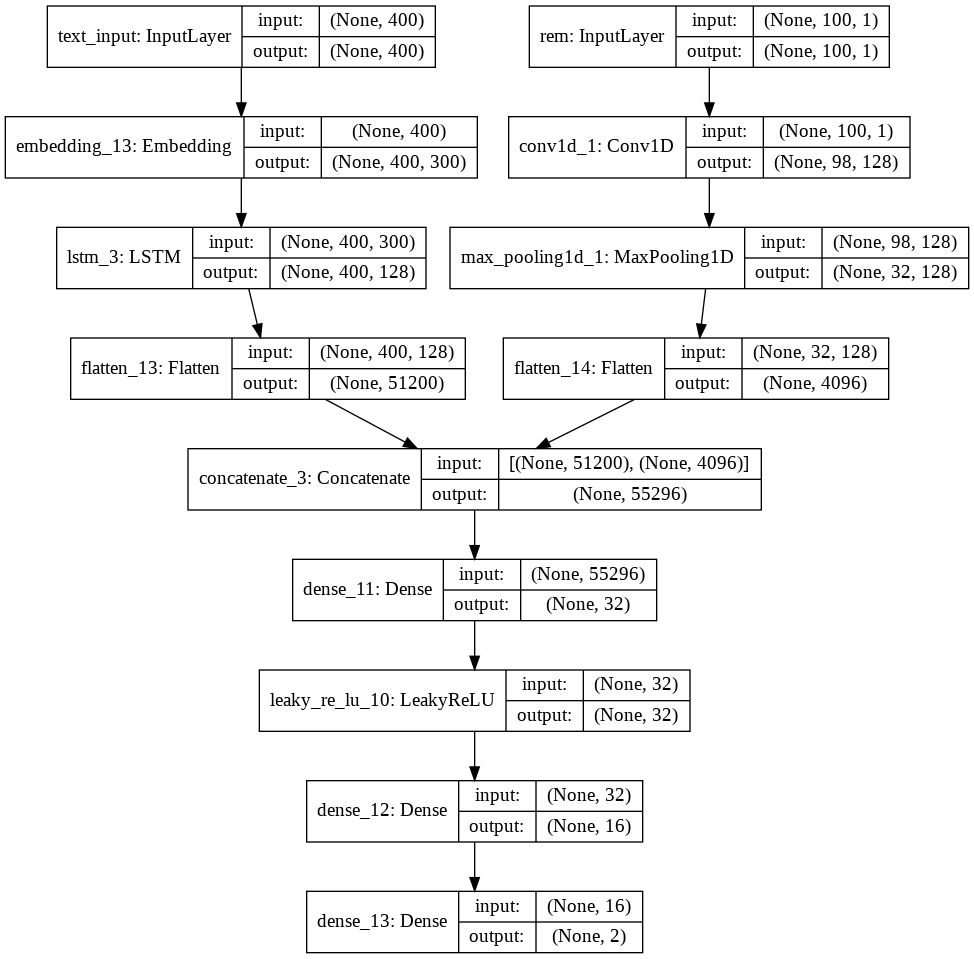

In [ ]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model_3, to_file='/content/drive/My Drive/LSTM_Output/model_3.png', show_shapes=True, show_layer_names=True)

In [ ]:

#https://stackoverflow.com/posts/51734992/revisions
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [ ]:
adam = keras.optimizers.Adam(lr=0.001)
model_3.compile(optimizer=adam, loss='categorical_crossentropy',metrics=[auroc])

In [ ]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr_3 = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.001,verbose = 1)

In [ ]:
earlystopping_3 = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(y_train,2)
y_cv = to_categorical(y_cv)
y_test = to_categorical(y_test)

In [ ]:
y_train.shape

(69918, 2)

In [ ]:
filepath = "/content/drive/My Drive/LSTM_Output"
earlystopping_3 = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

checkpoint_3 = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
tensorboard = TensorBoard(log_dir="/content/drive/My Drive/LSTM_Output/logs/{}".format(time()))
callbacks_list = [checkpoint_3,tensorboard, earlystopping_3, reduce_lr_3]

history_3= model_3.fit({'text_input': X_train_essay, 'rem':x_tr_rem_reshape}, y_train, nb_epoch=20, verbose=1, batch_size=256, validation_data=({'text_input': X_cv_essay, 'rem': x_cv_rem_reshape}  , y_cv), callbacks = callbacks_list)
model_3.save('/content/drive/My Drive/LSTM_Output/dc_model3.h5')

Train on 69918 samples, validate on 17480 samples
Epoch 1/20
69918/69918 [==============================] - 428s 6ms/step - loss: 0.5643 - auroc: 0.7110 - val_loss: 0.4278 - val_auroc: 0.7298
Epoch 2/20
69918/69918 [==============================] - 425s 6ms/step - loss: 0.3908 - auroc: 0.7623 - val_loss: 0.3955 - val_auroc: 0.7397
Epoch 3/20
69918/69918 [==============================] - 422s 6ms/step - loss: 0.3665 - auroc: 0.7884 - val_loss: 0.3875 - val_auroc: 0.7390
Epoch 4/20
69918/69918 [==============================] - 428s 6ms/step - loss: 0.3511 - auroc: 0.8067 - val_loss: 0.3937 - val_auroc: 0.7328

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 5/20
69918/69918 [==============================] - 427s 6ms/step - loss: 0.3383 - auroc: 0.8259 - val_loss: 0.4001 - val_auroc: 0.7324

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 00005: early stopping


In [ ]:
from keras.layers import MaxPooling1D
text_input = Input(shape=(400,), name = "text_input")
# max_length = 150 ---->max length of sentence

e1 = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=400)(text_input)

l1= LSTM(128,activation = "relu",dropout=0.5,kernel_regularizer=l2(0.001),kernel_initializer='glorot_normal',return_sequences=True,input_shape=(150,300))(e1)
#dout = Dropout(0.5)(l1)
f1= Flatten()(l1)

rem = Input(shape=(x_tr_rem.shape[1],1), name="rem")
rem_conv1 = Conv1D(128, 3,kernel_initializer='glorot_normal')(rem)
act1= LeakyReLU(alpha = 0.3)(rem_conv1)
#rem_conv2 =Conv1D(128, 3, activation='relu',kernel_initializer='glorot_normal' )(rem)
max_pool =MaxPooling1D(3)(rem_conv1)
#rem_conv3 =Conv1D(64, 3, activation='sigmoid')(max_pool)
#rem_conv4 =Conv1D(128, 3, activation='sigmoid')(rem_conv3)
f2= Flatten()(max_pool)
x = keras.layers.concatenate([f1,f2])
#x= Dense(256, activation='sigmoid')(x)
#x= Dropout(0.25)(x)
#x= Dense(128, kernel_regularizer=l2(0.001),kernel_initializer='glorot_normal')(x)
#x= LeakyReLU(alpha = 0.3)(x)
#x= Dropout(0.5)(x)
#x= Dense(64,kernel_regularizer=l2(0.001),kernel_initializer='glorot_normal')(x)
#x= LeakyReLU(alpha = 0.3)(x)
#x= Dropout(0.5)(x)
#x=BatchNormalization()(x)
x= Dense(32,kernel_regularizer=l2(0.001),kernel_initializer='glorot_normal')(x)
x= LeakyReLU(alpha = 0.3)(x)
#x= Dropout(0.5)(x)
x= Dense(16, activation='relu')(x)
output=Dense(2, activation='softmax')(x)
model_3 = Model(inputs=[text_input,rem], outputs=output)
model_3.compile(optimizer=adam, loss='categorical_crossentropy',metrics=[auroc])
model_3.load_weights("/content/drive/My Drive/LSTM_Output/dc_model3.h5")

In [ ]:
print("Auc for test data: %0.3f"%roc_auc_score(y_test,model_3.predict([X_test_essay,x_test_rem_reshape])))
print("Auc for CV data: %0.3f"%roc_auc_score(y_cv,model_3.predict([X_cv_essay,x_cv_rem_reshape])))
print("Auc for train data: %0.3f"%roc_auc_score( y_train,model_3.predict([X_train_essay,x_tr_rem_reshape])))

Auc for test data: 0.734
Auc for CV data: 0.732
Auc for train data: 0.858


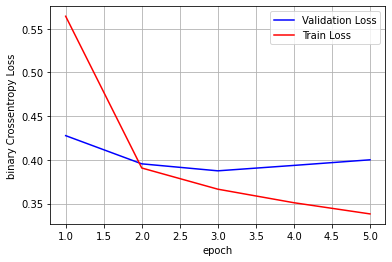

In [ ]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,5+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history_3.history['val_loss']
ty = history_3.history['loss']
plt_dynamic(x, vy, ty, ax)

#Conclusion

In [1]:
from prettytable import PrettyTable
pretty=PrettyTable()
pretty.field_names=["model","train_auc","cv_auc","test_auc"]
pretty.add_row(["model_1","0.788","0.737","0.752"])
pretty.add_row(["model_2","0.771","0.684","0.699"])
pretty.add_row(["model_3","0.85","0.73","0.73"])

print(pretty)

+---------+-----------+--------+----------+
|  model  | train_auc | cv_auc | test_auc |
+---------+-----------+--------+----------+
| model_1 |   0.788   | 0.737  |  0.752   |
| model_2 |   0.771   | 0.684  |  0.699   |
| model_3 |    0.85   |  0.73  |   0.73   |
+---------+-----------+--------+----------+


We can see that our model_1 has the best performance and model_2 has the worst performance.